In [ ]:
import openmeteo_requests
import requests_cache
import pandas as pd
import numpy as np

def get_ghi_curve():
    openmeteo = openmeteo_requests.Client(
        session = requests_cache.CachedSession(
            cache_name='openmeteo_cache',
            backend='memory'
        )
    )
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": 37.000495,
        "longitude": -86.36811,
        "hourly": ["shortwave_radiation_instant", "cloud_cover"],
    }
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]
    hourly = response.Hourly()

    hourly_shortwave_radiation_instant = hourly.Variables(0).ValuesAsNumpy()
    hourly_cloud_cover = hourly.Variables(1).ValuesAsNumpy()

    hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
    )}
    hourly_data["shortwave_radiation_instant"] = hourly_shortwave_radiation_instant
    hourly_data["cloud_cover"] = hourly_cloud_cover

    hourly_dataframe = pd.DataFrame(data = hourly_data)
    central_timezone = "America/Chicago"
    hourly_dataframe_central = hourly_dataframe.set_index("date").tz_convert(central_timezone)
    daytime_data = hourly_dataframe_central.between_time("10:00", "18:00")
    
    
    daytime_data = daytime_data[1:10]  # first day only
    daytime_data = daytime_data.reset_index()

    # resample to 1 minute intervals
    daytime_data = daytime_data.resample("min", on="date").mean()
    # interpolate shortwave radiation column with cubic spline
    daytime_data["shortwave_radiation_instant"] = daytime_data["shortwave_radiation_instant"].interpolate(method="spline", order=3)
    # interpolate cloud cover linearly
    daytime_data["cloud_cover"] = daytime_data["cloud_cover"].interpolate(method="linear")

    time_minutes = np.arange(0, len(daytime_data) * 1, 1) + 10 * 60  # minutes since midnight
    ghi_data = daytime_data["shortwave_radiation_instant"].to_numpy()
    cloud_data = daytime_data["cloud_cover"].to_numpy() / 100 

    return time_minutes, ghi_data, cloud_data

                           shortwave_radiation_instant  cloud_cover
date                                                               
2025-12-09 10:00:00-06:00                   397.458527       100.00
2025-12-09 11:00:00-06:00                   480.015259        27.50
2025-12-09 12:00:00-06:00                   499.440186         6.25
2025-12-09 13:00:00-06:00                   450.618713         0.00
2025-12-09 14:00:00-06:00                   349.379456         6.00
2025-12-09 15:00:00-06:00                   205.056473        86.00
2025-12-09 16:00:00-06:00                    50.273899        89.00
2025-12-09 17:00:00-06:00                     0.000000        81.00
2025-12-09 18:00:00-06:00                     0.000000        71.00


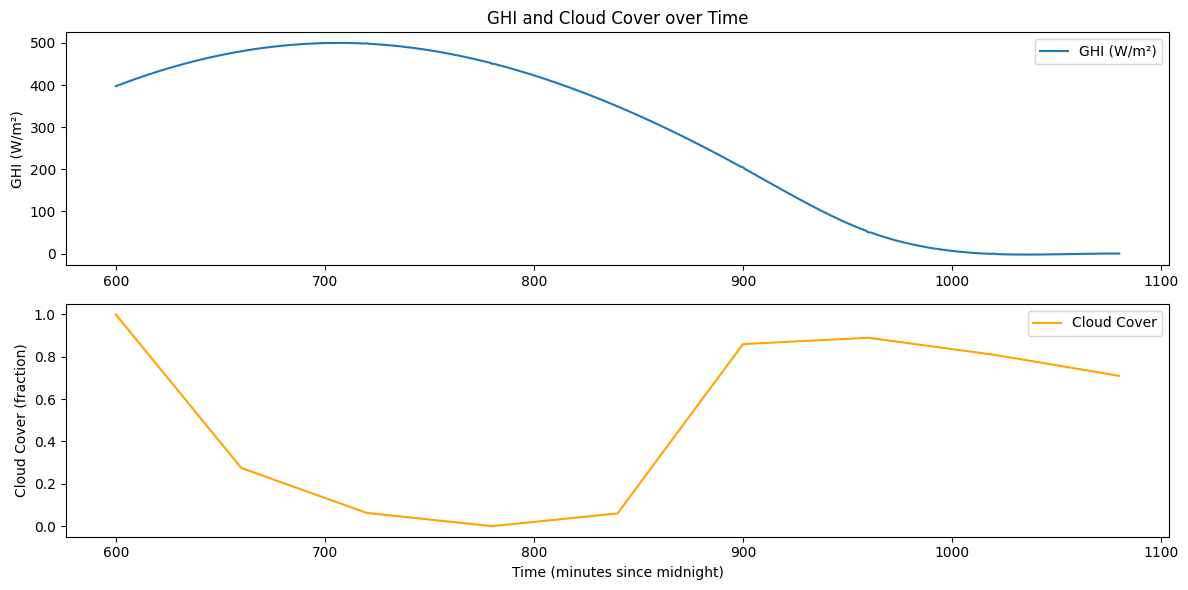

In [2]:
time, ghi, cloud = get_ghi_curve()
# Plotting for visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, ghi, label='GHI (W/m²)')
plt.title('GHI and Cloud Cover over Time')
plt.ylabel('GHI (W/m²)')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(time, cloud, label='Cloud Cover', color='orange')
plt.ylabel('Cloud Cover (fraction)')
plt.xlabel('Time (minutes since midnight)')
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
def ideal_soc_cloud2(start_soc, target_soc, cloud_data, alpha=0.5):

    """
    Calculate an ideal SoC curve that reacts to cloudiness:
    - Sunny (cloud low) → can use more battery (drop SoC faster)
    - Cloudy (cloud high) → conserve battery (drop SoC slower)
    alpha: controls strength of cloud impact (0=ignore clouds, 1=fully reactive)
    Ensures the final SoC is close to target_soc by normalizing cloud-weighted drops
    """
    n_steps = len(cloud_data)
    soc = np.zeros(n_steps)
    soc[0] = start_soc
    soc_drop_total = start_soc - target_soc
    
    # Calculate cloud-weighted factors for each step
    # More sunny (low cloud) → higher factor → faster drop
    cloud_factors = (1 - cloud_data) * alpha + (1 - alpha)
    
    # Normalize cloud factors so the total drop equals soc_drop_total
    total_weighted_steps = np.sum(cloud_factors)
    normalized_factors = cloud_factors * (soc_drop_total / total_weighted_steps)

    for i in range(1, n_steps):
        # Apply the normalized drop at each step
        soc[i] = soc[i-1] - normalized_factors[i]
        soc[i] = max(soc[i], target_soc)  # don't drop below target

    time_x = np.arange(n_steps)

    plt.figure(figsize=(8, 4))
    plt.plot(time_x, soc, label="Ideal SoC with Cloud Cover", linewidth=2)
    plt.plot(time_x, 1 - cloud_data * (1 - target_soc), "--", alpha=0.3, label="Cloud Cover (scaled)")
    plt.title("Ideal SoC with Cloud Cover")
    plt.xlabel("Time Step")
    plt.ylabel("State of Charge")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return soc

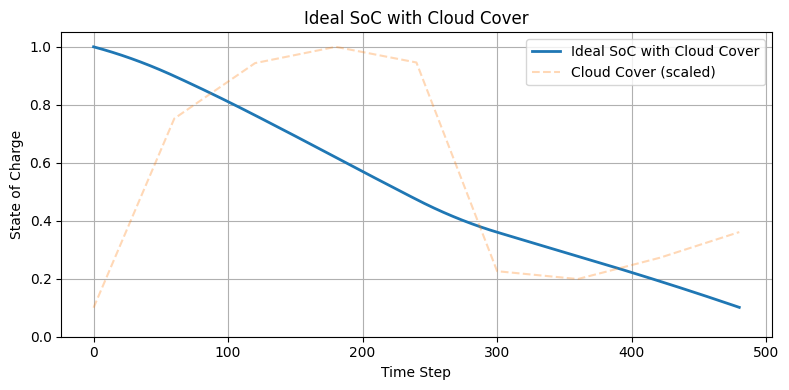

array([1.        , 0.99875631, 0.99749776, 0.99622437, 0.99493613,
       0.99363305, 0.99231511, 0.99098233, 0.98963469, 0.98827221,
       0.98689488, 0.9855027 , 0.98409567, 0.9826738 , 0.98123707,
       0.9797855 , 0.97831908, 0.97683781, 0.97534169, 0.97383072,
       0.9723049 , 0.97076424, 0.96920873, 0.96763836, 0.96605315,
       0.9644531 , 0.96283819, 0.96120843, 0.95956383, 0.95790438,
       0.95623007, 0.95454092, 0.95283693, 0.95111808, 0.94938438,
       0.94763584, 0.94587245, 0.9440942 , 0.94230111, 0.94049318,
       0.93867039, 0.93683275, 0.93498027, 0.93311294, 0.93123076,
       0.92933373, 0.92742185, 0.92549512, 0.92355355, 0.92159712,
       0.91962585, 0.91763973, 0.91563876, 0.91362294, 0.91159228,
       0.90954676, 0.9074864 , 0.90541119, 0.90332112, 0.90121622,
       0.89909646, 0.89697235, 0.89484389, 0.89271107, 0.8905739 ,
       0.88843239, 0.88628652, 0.88413629, 0.88198172, 0.87982279,
       0.87765951, 0.87549188, 0.8733199 , 0.87114356, 0.86896

In [4]:
ideal_soc_cloud2(1.0, 0.1, cloud)